In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import torchio as tio
import nibabel as nib
import matplotlib.pyplot as plt

c:\Users\benysar\Desktop\Github\stroke-occlusion\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Trying to scale myself

In [2]:
import os
import nibabel as nib

# Directory path
folder_path = 'E:/data/TOF3D_resliced/'

# List to store the unique shapes
unique_shapes = set()

# Iterate through each file in the directory
for filename in os.listdir(folder_path):
    if filename.endswith('.nii.gz'):
        file_path = os.path.join(folder_path, filename)
        try:
            # Load the file
            file = nib.load(file_path)

            # Get the shape of the file data and add to the set
            unique_shapes.add(file.get_fdata().shape)
        except Exception as e:
            print(f"Error loading file {filename}: {e}")



Choosing desired voxel size when resampling : computing the median of my images

In [3]:
def median_voxel_size(folder_path):
    voxel_sizes = []

    # Iterate through each file in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith('.nii.gz'):
            file_path = os.path.join(folder_path, filename)
            try:
                # Load the file
                image = nib.load(file_path)

                # Extract the affine matrix
                affine_matrix = image.affine

                # Calculate voxel size
                voxel_size = np.abs(np.diag(affine_matrix)[:3])  # Absolute value for voxel dimensions
                voxel_sizes.append(voxel_size)
            except Exception as e:
                print(f"Error loading file {filename}: {e}")

    # Compute the median voxel size
    median_size = np.median(voxel_sizes, axis=0) if voxel_sizes else None
    return median_size

# Example usage
folder_path = 'E:/data/TOF3D_resliced/'
median_size = median_voxel_size(folder_path)
print("Median Voxel Size:", median_size)


Median Voxel Size: [0.46851447 0.46561816 4.57942057]


In [4]:
from scipy.ndimage import zoom


def resample_image(nifti_file_path, target_voxel_size):
    """
        Resampling MRI images to a common voxel size involves adjusting the resolution of the images 
        so that each voxel (3D pixel) represents the same physical size across all images. 
        This process ensures consistency in spatial dimensions, which is crucial for many analyses and machine 
        learning applications in medical imaging.
    """
    # Load the image
    image = nib.load(nifti_file_path)
    print("Before resampling:",image.shape)
    data = image.get_fdata()

    # Current voxel size
    current_voxel_size = np.diag(image.affine)[:3]

    # Calculate resampling factor
    resample_factor = current_voxel_size / target_voxel_size

    # Resample data
    resampled_data = zoom(data, resample_factor)

    # Update affine (adjusting for the new voxel size)
    new_affine = np.copy(image.affine)
    np.fill_diagonal(new_affine, np.append(target_voxel_size, [1]))
    
    # Create a new NIfTI image
    resampled_image = nib.Nifti1Image(resampled_data, new_affine)
    print("After resampling:",resampled_image.shape)
    return resampled_image

# Example usage
target_voxel_size = [0.5, 0.5, 4]  # replace with your desired voxel size
resampled_nifti = resample_image('C:/Users/benysar/Desktop/Github/stroke-occlusion/data/envoi-20231207/2018-104_01-10087-D0MR/TOF3D/2018-104_01-10087-D0MR_resliced.nii.gz', target_voxel_size)
resampled_nifti2 = resample_image('C:/Users/benysar/Desktop/Github/stroke-occlusion/data/envoi-20231207/2018-104_05-10479-D0MR/TOF3D/2018-104_05-10479-D0MR_resliced.nii.gz', target_voxel_size)



Before resampling: (480, 640, 80)
After resampling: (345, 455, 40)
Before resampling: (512, 512, 76)
After resampling: (480, 451, 36)


Checking if the scaling had a lot of impact on our slices

Resampled nifti


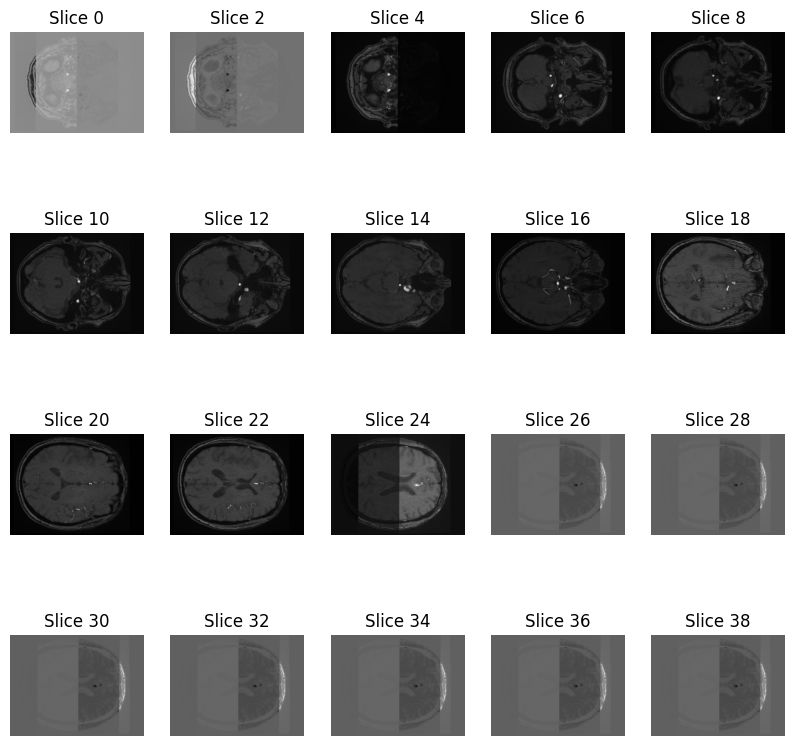

Raw nifti


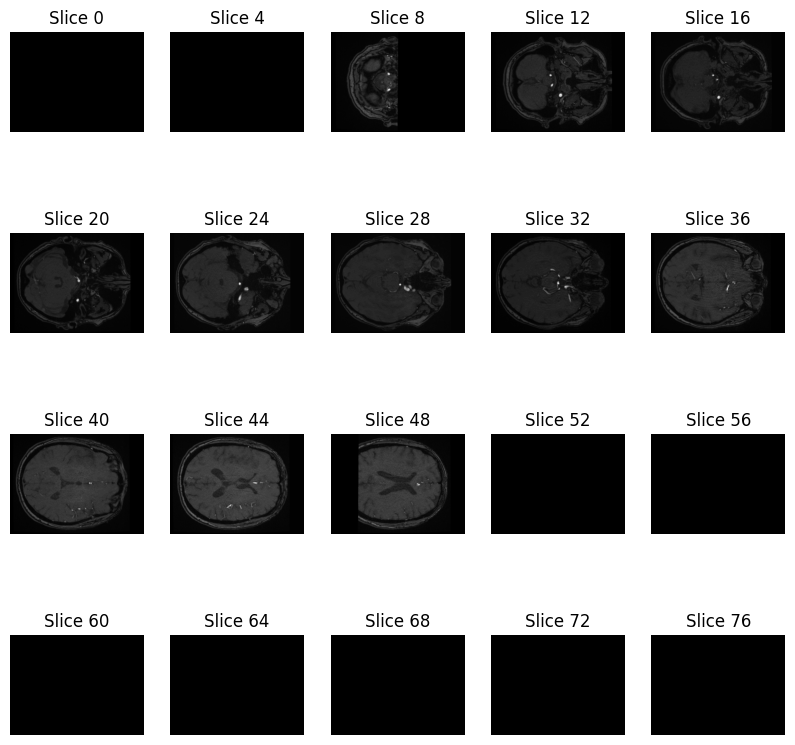

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def display_multiple_slices_from_resampled(nifti_resampled, num_slices, rows, cols):
    # Get the data from the resampled NIfTI image
    data = nifti_resampled.get_fdata()

    # Determine the axis along which to take slices (usually the last axis)
    slice_axis = data.ndim - 1

    # Calculate the step size to evenly sample slices
    step = data.shape[slice_axis] // num_slices

    # Set up the subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    # Loop to plot slices
    for i in range(num_slices):
        idx = i * step
        slice_data = np.take(data, indices=idx, axis=slice_axis)

        # Find the subplot to plot on
        ax = axes[i // cols, i % cols]
        ax.imshow(slice_data, cmap='gray')  # Adjust the colormap if needed
        ax.set_title(f'Slice {idx}')
        ax.axis('off')  # Turn off axis numbers and labels

    # Hide any unused subplots
    for i in range(num_slices, rows * cols):
        axes[i // cols, i % cols].axis('off')

    plt.show()

# Example usage
# Suppose 'resampled_nifti' is your resampled NIfTI image
num_slices = 20  # Total number of slices to display
rows = 4  # Number of rows in the subplot grid
cols = 5  # Number of columns in the subplot grid

print("Resampled nifti")
display_multiple_slices_from_resampled(resampled_nifti, num_slices, rows, cols)
print("Raw nifti")
display_multiple_slices_from_resampled(nib.load('C:/Users/benysar/Desktop/Github/stroke-occlusion/data/envoi-20231207/2018-104_01-10087-D0MR/TOF3D/2018-104_01-10087-D0MR_resliced.nii.gz'), num_slices, rows, cols)


## Testing Using torchio instead 

In [7]:
image_paths = []
folder_path = 'E:/data/TOF3D_resliced/'
for filename in os.listdir(folder_path):
    if filename.endswith('.nii.gz'):
        image_paths.append(os.path.join(folder_path, filename))

print("Number of images :",len(image_paths))

Number of images : 507


In [8]:
def stat_image_shape(folder_path):
    shapes = []

    # Iterate through each file in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith('.nii.gz'):
            file_path = os.path.join(folder_path, filename)
            try:
                # Load the file
                image = nib.load(file_path)

                # Get the shape of the image
                shapes.append(image.shape)
            except Exception as e:
                print(f"Error loading file {filename}: {e}")

    # Calculate the median shape
    shapes = np.array(shapes)
    if shapes.size == 0:
        return None
    min_shape = np.min(shapes, axis=0).astype(int)
    median_shape = np.median(shapes, axis=0).astype(int)
    avg_shape = np.average(shapes, axis=0).astype(int)
    max_shape = np.max(shapes, axis=0).astype(int)

    return min_shape, median_shape, avg_shape, max_shape

min_shape, median_shape, avg_shape, max_shape = stat_image_shape(folder_path)
print("Minimum Image Shape:", list(min_shape))
print("Median Image Shape:", list(median_shape))
print("Average Image Shape:", list(avg_shape))
print("Maximum Image Shape:", list(max_shape))

Minimum Image Shape: [168, 222, 18]
Median Image Shape: [480, 512, 30]
Average Image Shape: [450, 477, 55]
Maximum Image Shape: [768, 768, 224]


### Choosing an Optimal Image Size for Preprocessing

When standardizing the size of 3D MRI images in our dataset, our goal is to balance several key factors: minimizing information loss, maintaining computational efficiency, and ensuring practicality in processing. Here's our approach:

#### Balanced Size Selection:
- **Aim**: Select a size slightly larger than the median to minimize information loss, but smaller than the average or maximum to reduce computational load.
- **Strategy**: Use a weighted average of the median and average shapes, focusing particularly on the depth dimension. This provides a balanced compromise:
  - **Larger than the Median**: Ensures less critical information is lost.
  - **Smaller than the Average**: Keeps computational resources in check.
- **Formula**: `
Balanced Shape = w * Median Shape + (1 - w) * Average Shape
`

where `w` is a weight factor (between 0 and 1) determining the relative importance of the median and average shapes.


In [9]:
# Weight for the median shape
w = 0.5  

# Calculate the balanced shape
balanced_shape = (w * np.array(list(median_shape)) + (1 - w) * np.array(list(avg_shape))).astype(int)

print("Balanced Image Shape:", list(balanced_shape))

Balanced Image Shape: [465, 494, 42]


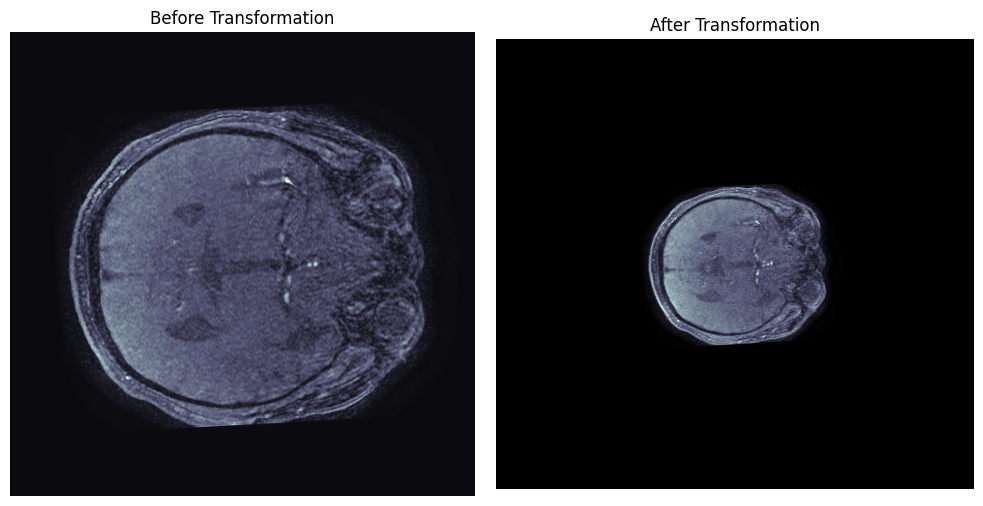

Image before : (1, 512, 512, 24)
Image after : (1, 465, 494, 42)


In [10]:
import matplotlib.pyplot as plt
import torchio as tio
import random

def show_slices(side_by_side, titles=['Before', 'After'], cmap='bone'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    for i, (img, title) in enumerate(zip(side_by_side, titles)):
        ax = axes[i]
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the image
image_path = image_paths[random.choice([1, 506])]  # Replace with your image path
subject = tio.Subject(mri=tio.ScalarImage(image_path))
image = subject['mri']

# Extract a slice before transformation
slice_before = image.data[0, :, :, image.shape[-1] // 2].numpy()

# Define the transformations
transforms = tio.Compose([
    tio.Resample(1),
    tio.CropOrPad(list(balanced_shape)),
    tio.ZNormalization(),
    # Add more transforms as needed
])

# Apply the transformations
transformed_subject = transforms(subject)
transformed_image = transformed_subject['mri']

# Extract a slice after transformation
slice_after = transformed_image.data[0, :, :, transformed_image.shape[-1] // 2].numpy()

# Display slices side by side
show_slices([slice_before, slice_after], titles=['Before Transformation', 'After Transformation'])
print("Image before :", image.shape)
print("Image after :", transformed_image.shape)



In [11]:
subjects = []
for image_path in image_paths:
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        # You can also add labels or other types of images (e.g., segmentation maps)
    )
    subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)

transforms = tio.Compose([
    tio.Resample(1),  # Resample to 1mm isotropic voxels
    tio.CropOrPad(list(balanced_shape)),
    tio.ZNormalization(),  # Normalize intensity values
])

subjects = [tio.Subject(mri=tio.ScalarImage(image_path)) for image_path in image_paths]
dataset_transformed = tio.SubjectsDataset(subjects, transform=transforms)



In [12]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset_transformed, batch_size=1, shuffle=True)
for batch in data_loader:
    mri_images = batch['mri'][tio.DATA]
    # Process the images as needed
